In [1]:
!pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc3)


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/train" -d "/content/drive/My Drive/train"

In [4]:
!unzip -uq "/content/drive/My Drive/test1" -d "/content/drive/My Drive/test1"

replace /content/drive/My Drive/test1/test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [0]:

import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [0]:
train = '/content/drive/My Drive/train/train'
test = '/content/drive/My Drive/test1/test1'

In [0]:



filenames = os.listdir(train)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
df.head()

,filename,category
0,cat.9072.jpg,0
1,cat.9087.jpg,0
2,cat.9077.jpg,0
3,cat.9074.jpg,0
4,cat.9113.jpg,0


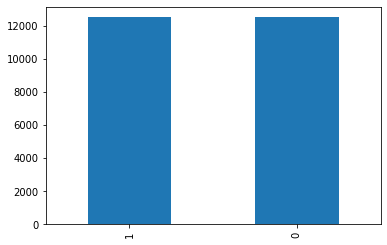

In [9]:
df['category'].value_counts().plot.bar()

In [0]:


from sklearn.utils import shuffle
df = shuffle(df)

In [11]:
df.tail()

,filename,category
20888,dog.3139.jpg,1
9863,cat.177.jpg,0
17351,dog.539.jpg,1
15233,dog.7035.jpg,1
10405,cat.11725.jpg,0


In [0]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=15

In [0]:



df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15


In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/My Drive/train/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/My Drive/train/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import SGD
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)       

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [0]:
import tensorflow as tf
import os
import cv2

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [38]:

history = model.fit(
    train_generator, 
    epochs=4,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/4
1333/1333 [==============================] - 365s 274ms/step - loss: 0.6424 - accuracy: 0.6645 - val_loss: 0.5788 - val_accuracy: 0.7151
Epoch 2/4
1333/1333 [==============================] - 195s 146ms/step - loss: 0.6347 - accuracy: 0.6735 - val_loss: 0.5795 - val_accuracy: 0.6837
Epoch 3/4
1333/1333 [==============================] - 197s 148ms/step - loss: 0.6118 - accuracy: 0.6886 - val_loss: 0.5310 - val_accuracy: 0.7496
Epoch 4/4
1333/1333 [==============================] - 198s 149ms/step - loss: 0.5877 - accuracy: 0.7078 - val_loss: 0.6590 - val_accuracy: 0.6911
